# Two-Armed Bandit Reinforcement Learning

This example demonstrates parameter recovery for a simple two-armed bandit
reinforcement learning task.  On each trial the participant chooses between two
options with different reward probabilities.  Choices are generated with a
Rescorla–Wagner model using an inverse-temperature parameter (``beta``) and a
learning rate (``alpha``).

In [5]:
import numpy as np
from scipy.stats import truncnorm, beta as beta_dist
from pyem import EMModel
from pyem.models.rl import rw1a1b_simulate, rw1a1b_fit
from pyem.utils.math import norm2beta, norm2alpha

In [2]:
# simulate computer agents completing the two-armed task
nsubjects, nblocks, ntrials = 100, 6, 24
betamin, betamax = .75, 10 # inverse temperature
alphamin, alphamax = .05, .95 # learning rate

# generate distribution of parameters within range
beta_rv  = truncnorm((betamin-0)/1, (betamax-0)/1, loc=0, scale=2).rvs(nsubjects)
a_lo, a_hi = beta_dist.cdf([alphamin, alphamax], 1.1, 1.1)
alpha_rv = beta_dist.ppf(a_lo + np.random.rand(nsubjects)*(a_hi - a_lo), 1.1, 1.1)
true_params = np.column_stack((beta_rv, alpha_rv))

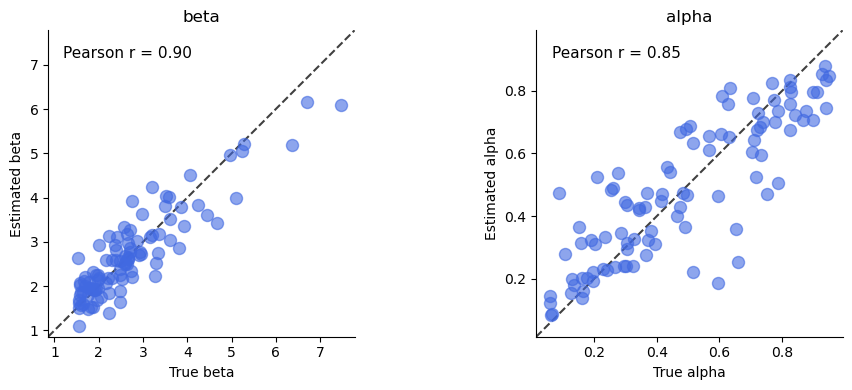

In [3]:
# use EMModel.recover to run simulation, fitting and recovery metrics
model = EMModel(all_data=None, fit_func=rw1a1b_fit,
                param_names=["beta", "alpha"],
                param_xform=[norm2beta, norm2alpha], 
                simulate_func=rw1a1b_simulate)

recovery = model.recover(true_params, 
                         pr_inputs=['choices','rewards'], 
                         nblocks=nblocks, ntrials=ntrials
                         )

# scatter plot of recovered parameters
fig = model.plot_recovery(recovery)

The recovery dictionary also contains numerical summaries such as
`recovery['correlation']`, which provides a correlation coefficient for each
parameter.

<hr>

### Social Reinforcement Learning

The following two examples demonstrate parameter recovery for different versions of a social two-armed bandit reinforcement learning task, in which the agent learns how their actions affect themselves and another target. On each trial the agent chooses between two options with different reward probabilities. Choices are generated with an adapted Rescorla–Wagner model using an inverse-temperature parameter (``beta``) and distinct learning rates (``alpha``) depending on the target.

#### **1. Prosocial Learning Task (Lockwood et al., 2016)** - 1Q3α1β Model

Participants learn to make choices to win points for themselves (self), a stranger (other), or noone (noone) in separate conditions. Rewards include gaining points (+100) or not gaining points (0) on any given trial, which are later converted to real-world payouts.

The model is an adapated Rescorla Wagner model with 3 different learning rates $\alpha_i^\ast$ for each target (self, other, noone):

  
    
$$
\textbf{Cached value update:}\quad
Q_{t+1}^k = Q_t^k + \alpha_i^\ast \cdot \delta_t \tag{1}
$$

$$
\textbf{Prediction error:}\quad
\delta_t = r_t - Q_t^k \tag{2}
$$

$$
\textbf{Learning rates:}\quad
\alpha_i^\ast =
\begin{cases}
\alpha_{\text{self}},  & \text{if } i=\text{self},\\[4pt]
\alpha_{\text{other}}, & \text{if } i=\text{other},\\[4pt]
\alpha_{\text{noone}}, & \text{if } i=\text{noone}.
\end{cases}
\tag{3}
$$

$$
\textbf{Choice rule (softmax):}\quad
p_t(\text{choose }k)=\frac{\exp(\beta \cdot Q_t^k)}{\sum_{j=1}^{K}\exp(\beta \cdot Q_t^j)} \tag{4}
$$


In [21]:
import numpy as np
from scipy.stats import truncnorm, beta as beta_dist
from pyem import EMModel
from pyem.utils.math import norm2beta, norm2alpha

from pyem.models.rl import rw3a1b_simulate, rw3a1b_fit

In [22]:
# simulate computer agents completing the two-armed task
nsubjects, nblocks, ntrials = 100, 9, 16
betamin, betamax = .75, 10 # inverse temperature
alphamin, alphamax = .05, .95 # learning rate

# generate distribution of parameters within range
beta_rv  = truncnorm((betamin-0)/1, (betamax-0)/1, loc=0, scale=2).rvs(nsubjects)
a_lo, a_hi = beta_dist.cdf([alphamin, alphamax], 1.1, 1.1)
alpha_rv = beta_dist.ppf(a_lo + np.random.rand(nsubjects)*(a_hi - a_lo), 1.1, 1.1)
true_params = np.column_stack((beta_rv, alpha_rv, alpha_rv, alpha_rv))

In [25]:
# use EMModel.recover to run simulation, fitting and recovery metrics
model = EMModel(all_data=None, fit_func=rw3a1b_fit,
                param_names=["beta", "a_self", "a_other", "a_noone"],
                param_xform=[norm2beta, norm2alpha, norm2alpha, norm2alpha], 
                simulate_func=rw3a1b_simulate)

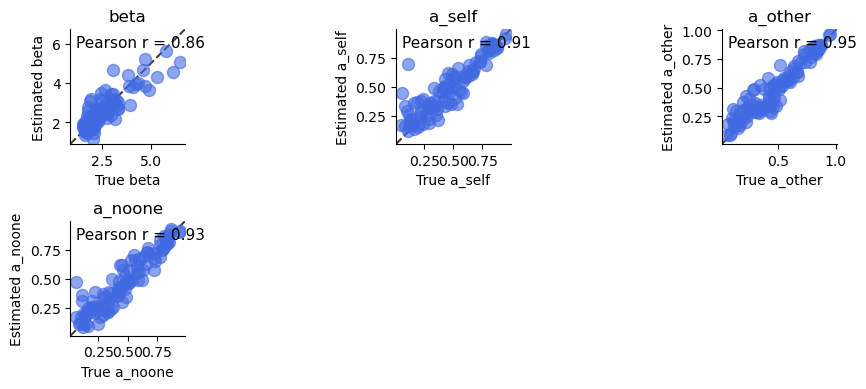

In [26]:
recovery = model.recover(true_params, 
                         pr_inputs=['choices','rewards'], 
                         nblocks=nblocks, ntrials=ntrials
                         )

# scatter plot of recovered parameters
fig = model.plot_recovery(recovery)

#### **2. Dual Outcome Social Learning Task (Rhoads et al., 2025)** - 4α1β

Participants learn to make choices to win points for themselves (self) and a stranger (other) simultaneously. Rewards include gaining points (+100), not gaining points (0), or losing points (-100), which are later converted to real-world payouts. Outcome options are:

**A:** ++ Mutual Benefit (self gain, other gain)  
**B:** +- Instrumental Harm (self gain, other loss)  
**C:** -+ Altruism (self loss, other gain)  
**D:** -- Mutual Cost (self loss, other loss)  

The model is an adapated Rescorla Wagner model with four different learning rates $\alpha_i^\ast$ for different targets (self, other) and valence (positive, negative):

$$
\textbf{Cached value update:}\quad
Q_{t+1}^k = Q_t^k + \alpha_i^\ast\,\delta_t \tag{1}
$$

$$
\textbf{Prediction error:}\quad
\delta_t = r_t - Q_t^k \tag{2}
$$

$$
\textbf{Learning rates:}\quad
\alpha_i^\ast =
\begin{cases}
\alpha_{\text{self}}^{+},   & \text{if } i=\text{self and } \delta_t \ge 0,\\
\alpha_{\text{other}}^{+},  & \text{if } i=\text{other and } \delta_t \ge 0,\\
\alpha_{\text{self}}^{-},   & \text{if } i=\text{self and } \delta_t < 0,\\
\alpha_{\text{other}}^{-},  & \text{if } i=\text{other and } \delta_t < 0.
\end{cases}
\tag{3}
$$

$$
\textbf{Choice rule (softmax):}\quad
p_t(\text{choose }k)=\frac{\exp(\beta Q_t^k)}{\sum_{j=1}^{K}\exp(\beta Q_t^j)} \tag{4}
$$


In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
from scipy.stats import truncnorm, beta as beta_dist
from pyem import EMModel
from pyem.utils.math import norm2beta, norm2alpha

from pyem.models.rl import rw4a1b_simulate, rw4a1b_fit

In [2]:
# simulate computer agents completing the two-armed task
nsubjects, nblocks, ntrials = 100, 12, 20
betamin, betamax = .75, 10 # inverse temperature
alphamin, alphamax = .05, .95 # learning rate

# generate distribution of parameters within range
beta_rv  = truncnorm((betamin-0)/1, (betamax-0)/1, loc=0, scale=2).rvs(nsubjects)
a_lo, a_hi = beta_dist.cdf([alphamin, alphamax], 1.1, 1.1)
alpha_rv = beta_dist.ppf(a_lo + np.random.rand(nsubjects)*(a_hi - a_lo), 1.1, 1.1)
true_params = np.column_stack((beta_rv, alpha_rv, alpha_rv, alpha_rv, alpha_rv))

In [3]:
# use EMModel.recover to run simulation, fitting and recovery metrics
model = EMModel(all_data=None, fit_func=rw4a1b_fit,
                param_names=["beta", "a_self_pos", "a_self_neg", "a_other_pos", "a_other_neg"],
                param_xform=[norm2beta, norm2alpha, norm2alpha, norm2alpha, norm2alpha], 
                simulate_func=rw4a1b_simulate)

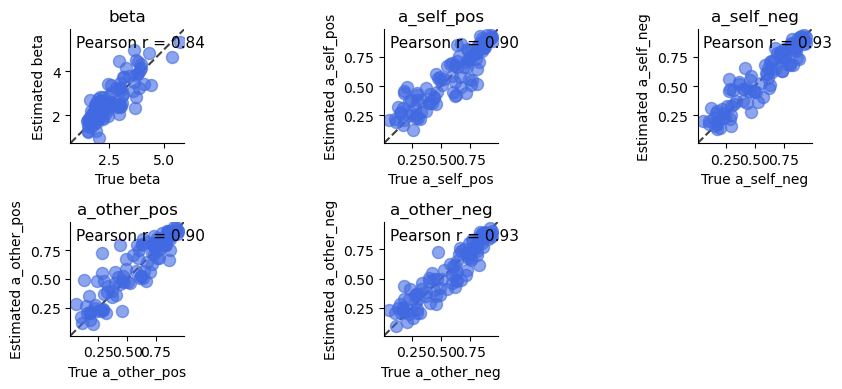

In [4]:
recovery = model.recover(
    true_params,
    pr_inputs=['choices', 'outcomes_self', 'outcomes_other', 'option_pairs'],  
    nblocks=nblocks, 
    ntrials=ntrials
)

# scatter plot of recovered parameters
fig = model.plot_recovery(recovery)

**References**

Lockwood, P. L., Apps, M. A., Valton, V., Viding, E., & Roiser, J. P. (2016). Neurocomputational mechanisms of prosocial learning and links to empathy. Proceedings of the National Academy of Sciences, 113(35), 9763-9768. https://www.pnas.org/doi/full/10.1073/pnas.1603198113

Rhoads, S. A., Gan, L., Berluti, K., OConnell, K., Cutler, J., Lockwood, P., & Marsh, A. (2025). Neurocomputational basis of learning when choices simultaneously affect both oneself and others. Nature Communications. https://doi.org/10.1038/S41467-025-64424-9